In [1]:
import os
import pandas as pd 
import matplotlib
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
#import shap
import seaborn as sns
import itertools as it
from sklearn.feature_selection import RFE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from openpyxl import Workbook, load_workbook

from openpyxl import Workbook
from openpyxl.drawing.image import Image

sns.set_style("whitegrid")

#os.chdir('/lustre/home/reynaj/Projects/20241011.kevin_byrd.ibd_nulisa')
os.chdir('/home/reynaj/projects/kevin_byrd/20241011.kevin_byrd.ibd_nulisa')
outdir = 'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/'

os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

## Load the data

In [2]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t")
protein_data = protein_data.T

# extract triplet
protein_data = protein_data.loc[:,:]

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

In [3]:
# remove alamar samples
# keep = (~clinical_data['sample_id'].str.contains('SC_Rep') | clinical_data.event_name == 1.0).tolist()
keep = (clinical_data.event_name == 1.0).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

In [4]:
# extract just CD and UC data
focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
clinical_data = clinical_data.iloc[focus_idxs]
protein_data = protein_data.iloc[focus_idxs, :]

In [5]:
protein_data.head()

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,0.000000,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,5.131593,11.29977,0.000000,18.23974,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,7.467110,11.17309,0.000000,18.78044,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662


In [6]:
clinical_data.head()

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
0,Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1.0,A1,1100.0,TRP-34082,1.0,CD,2023-11-30,Quiescent,1.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
1,Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1.0,A2,1100.0,TRP-34086,1.0,CD,2023-11-30,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
2,Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1.0,A3,1000.0,TRP-42335,1.0,CD,2023-12-20,Quiescent,7.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
3,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,TRP-42324,1.0,UC,2023-12-20,Quiescent,6.0,NaN,IBD Super Group,In-active Disease,9.0,Moderate
4,Byrd_IBD_Saliva_sup,Saliva,TRP-42322,2023-12-20 13:53:28.319,1.0,A5,1000.0,TRP-42322,1.0,CD,2023-12-20,Quiescent,5.0,NaN,IBD Super Group,In-active Disease,1.0,Mild


In [7]:
clinical_data.shape

(52, 18)

## Predicting IBD Diagnosis

In [8]:
# Extract the diagnosis column as the task data
task_data = clinical_data['ibd_diagnosis']

### Run Recursive Feature Selection

In [9]:
def test_feature_set(features):

    # split the data first
    X_train, X_test, y_train, y_test = train_test_split(protein_data.loc[:, features], task_data, test_size=0.2, random_state=random_state)

    # resample the data second (used to balance classes; training data only or else you introduce leakage)
    X_train_resampled, y_train_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)

    # create a model object
    model = linear_model.LogisticRegression(random_state=0, max_iter=1000)

    # Fit the model on the training data
    model.fit(X_train_resampled, y_train_resampled)

    # Check the accuracy on the training data
    train_accuracy = model.score(X_train_resampled, y_train_resampled)

    # Check the accuracy on the test data
    test_accuracy = model.score(X_test, y_test)

    return([model, train_accuracy, test_accuracy])


In [10]:
# Initialize the model and RFE
model = linear_model.LogisticRegression(random_state=0, max_iter=1000)

# init results
results = []
rfe_selected_lists = {}
rfe_order_data = []

# try out models from 2 upto 21 features
for n in range(3, 21):
#for n in range(16, 17):

    print(f'testing: {n}')
    rfe = RFE(model, n_features_to_select=n)

    # Fit RFE to the data
    rfe.fit(protein_data, task_data)

    # Get the selected features
    selected_features = rfe.get_support()
    feature_ranking = rfe.ranking_
    # features_ranked = pd.DataFrame.from_dict({'feature': protein_data.columns.tolist(), 'rank': feature_ranking, 'selected': selected_features})

    # get the selected features
    tselected_features_list = rfe.get_feature_names_out()

    # order the features by their cofficient strength
    order_df = pd.DataFrame.from_dict({'coef': rfe.estimator_.coef_[0], 'protein': tselected_features_list})
    order_df.loc[:, 'abs_coef'] = order_df.coef.apply(abs)
    order_df.sort_values('abs_coef', ascending=False)
    order_df.loc[:, 'n'] = n
    rfe_order_data.append(order_df)

    rfe_selected_lists[n] = order_df.protein.tolist()

    # rerun the model with ALL features
    curr_model, train_accuracy, test_accuracy = test_feature_set(tselected_features_list)
    results.append([n, train_accuracy, test_accuracy])

# run with all features
selected_features_list = protein_data.columns.tolist()
_, train_accuracy, test_accuracy = test_feature_set(selected_features_list)
results.append([len(selected_features_list), train_accuracy, test_accuracy])

testing: 3
testing: 4
testing: 5
testing: 6
testing: 7
testing: 8
testing: 9
testing: 10
testing: 11
testing: 12
testing: 13
testing: 14
testing: 15
testing: 16
testing: 17
testing: 18
testing: 19
testing: 20


In [11]:
all_rfe_order_data = pd.concat(rfe_order_data, axis=0)
all_rfe_order_data.loc[:, 'present'] = 1
all_rfe_order_matrix = all_rfe_order_data.pivot(index='protein', columns='n', values='present').fillna(0)
all_rfe_order_matrix = all_rfe_order_matrix.loc[all_rfe_order_data.protein.unique().tolist(),:]

<Axes: xlabel='protein', ylabel='n'>

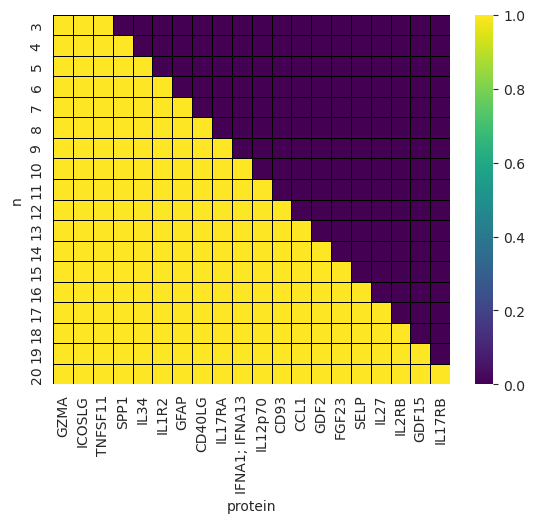

In [12]:
sns.heatmap(all_rfe_order_matrix.T, linecolor='black', linewidths=0.5, cmap='viridis')

In [13]:
results_df = pd.DataFrame(results, columns=['num_features', 'train_acc', 'test_acc'])

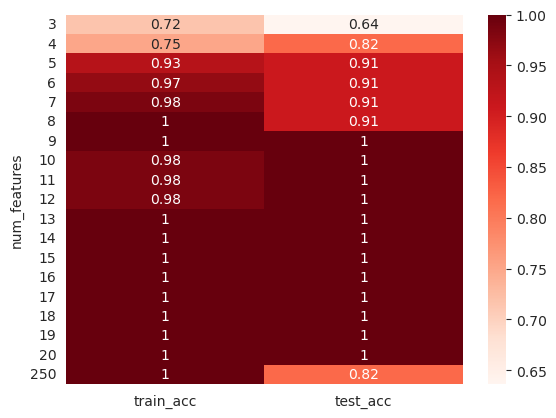

In [14]:
fig, ax = plt.subplots()
sns.heatmap(results_df.set_index('num_features'), cmap=sns.color_palette('Reds', as_cmap=True), vmax=1, annot=True, ax=ax)

ax.tick_params(axis='y', rotation=0)

outfn = os.path.join(outdir, 'rfe_analysis.svg')
fig.savefig(outfn)

In [15]:
rfe_selected_lists[9]

['CD40LG',
 'GFAP',
 'GZMA',
 'ICOSLG',
 'IL17RA',
 'IL1R2',
 'IL34',
 'SPP1',
 'TNFSF11']

In [16]:
results_df

,num_features,train_acc,test_acc
0,3,0.716667,0.636364
1,4,0.750000,0.818182
2,5,0.933333,0.909091
3,6,0.966667,0.909091
4,7,0.983333,0.909091
5,8,1.000000,0.909091
6,9,1.000000,1.000000
7,10,0.983333,1.000000
8,11,0.983333,1.000000
9,12,0.983333,1.000000


### Checking the model with these selected features using 5-fold cross validation

In [858]:
selected_n = 20
selected_features_list = rfe_selected_lists[selected_n]
print(f'num features: {len(selected_features_list)}')

num features: 20


In [859]:
def get_precision_recall_fscore_support_hvector(y_test, predictions, labels):
    
    report = precision_recall_fscore_support(y_test, predictions, labels=labels)
    report = pd.DataFrame(report, columns=labels, index=['precision', 'recall', 'fscore', 'support'])
    report = report.stack().swaplevel(1,0).sort_index().to_frame().T
    report.columns = [f'{i}_{j}' for i, j in report.columns]

    return(report.iloc[0])

In [860]:
labels = ['CD', 'UC']
results_skf = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
splits = skf.split(protein_data, task_data)
for i, (train_index, test_index) in enumerate(splits):

    # extract data from splits
    X_train, X_test = protein_data.iloc[train_index].loc[:,selected_features_list], protein_data.iloc[test_index].loc[:,selected_features_list]
    y_train, y_test = task_data.iloc[train_index], task_data.iloc[test_index]

    # get breakdown of the y test
    y_test_breakdown = pd.value_counts(y_test)
    # print(y_train.shape, y_test.shape)

    # resample to balance classes
    X_train_resampled, y_train_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)

    # Fit the model on the training data
    model = linear_model.LogisticRegression(random_state=0, max_iter=1000)
    model.fit(X_train_resampled, y_train_resampled)

    # Check the accuracy on the training data
    train_accuracy = model.score(X_train_resampled, y_train_resampled)

    # Check the accuracy on the test data
    test_accuracy = model.score(X_test, y_test)

    # get the report
    predictions = model.predict(X_test)
    report = get_precision_recall_fscore_support_hvector(y_test, predictions, labels)

    # append results
    results_skf.append([i, train_accuracy, test_accuracy] + report.values.tolist())


/tmp/ipykernel_85540/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_85540/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_85540/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_85540/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_85540/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use

In [861]:
#results_skf_df = pd.DataFrame(results_skf, columns=['fold', 'train_acc', 'test_acc'])
results_skf_df = pd.DataFrame(results_skf, columns=['fold', 'train_acc', 'test_acc'] + report.index.tolist())
results_skf_df

,fold,train_acc,test_acc,CD_fscore,CD_precision,CD_recall,CD_support,UC_fscore,UC_precision,UC_recall,UC_support
0,0,1.0,1.0,1.000000,1.0,1.000,8.0,1.0,1.000000,1.0,3.0
1,1,1.0,1.0,1.000000,1.0,1.000,8.0,1.0,1.000000,1.0,3.0
2,2,1.0,0.9,0.933333,1.0,0.875,8.0,0.8,0.666667,1.0,2.0
3,3,1.0,1.0,1.000000,1.0,1.000,8.0,1.0,1.000000,1.0,2.0
4,4,1.0,0.9,0.933333,1.0,0.875,8.0,0.8,0.666667,1.0,2.0


### Checking the model with these selected features using leave one out validation

In [862]:
def calculate_loo_validation_results(protein_data, task_data, selected_features_list, random_state):
    
    results_loo = []
    loo = LeaveOneOut()
    splits = loo.split(protein_data, task_data)
    for i, (train_index, test_index) in enumerate(splits):
    
        # extract data from splits
        X_train, X_test = protein_data.iloc[train_index].loc[:,selected_features_list], protein_data.iloc[test_index].loc[:,selected_features_list]
        y_train, y_test = task_data.iloc[train_index], task_data.iloc[test_index]
    
        # resample to balance classes
        X_train_resampled, y_train_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
    
        # Fit the model on the training data
        model = linear_model.LogisticRegression(random_state=0, max_iter=1000)
        model.fit(X_train_resampled, y_train_resampled)
    
        # Check the accuracy on the training data
        train_accuracy = model.score(X_train_resampled, y_train_resampled)
    
        # get the match result
        pred = model.predict(X_test)[0]
        real = y_test.iloc[0]
        match = (pred == real)

        # get probs for better roc curve
        probs =model.predict_proba(X_test) 
        # print(probs)
        # print(probs.shape)
        # print(model.classes_)

        # append results
        results_loo.append([train_accuracy, pred, real, match, probs])
        
    return results_loo


In [863]:
results_loo = calculate_loo_validation_results(protein_data, task_data, selected_features_list, random_state)

In [864]:
results_loo_df = pd.DataFrame(results_loo, columns=['train_acc', 'predicted', 'true', 'match', 'probs'])

In [865]:
cm_loo = results_loo_df[['predicted', 'true']].value_counts().sort_index()
cm_loo = cm_loo.to_frame().reset_index().pivot(index='true', columns='predicted', values='count')
cm_loo.fillna(0, inplace=True)

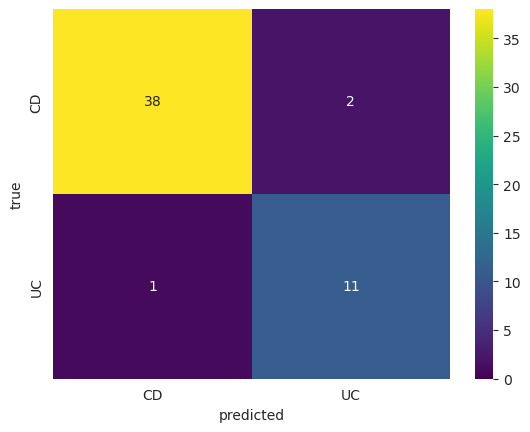

In [866]:
fig, ax = plt.subplots()

sns.heatmap(cm_loo, annot=True, cmap='viridis', ax=ax, vmin=0, vmax=cm_loo.values.max())

outfn = os.path.join(outdir, 'confusion_matrix.leave_one_out.svg')
fig.savefig(outfn)

In [867]:
results_loo_df['match'].value_counts()

match
True     49
False     3
Name: count, dtype: int64

In [868]:
results_loo_df['match'].value_counts(normalize=True) * 100

match
True     94.230769
False     5.769231
Name: proportion, dtype: float64

In [869]:
results_loo_df.head()

,train_acc,predicted,true,match,probs
0,1.0,UC,CD,False,"[[0.07047913580846632, 0.9295208641915337]]"
1,1.0,CD,CD,True,"[[0.9972152854665581, 0.00278471453344185]]"
2,1.0,UC,CD,False,"[[0.2483184689663417, 0.7516815310336583]]"
3,1.0,UC,UC,True,"[[0.016352994585193348, 0.9836470054148067]]"
4,1.0,CD,CD,True,"[[0.999989411601468, 1.0588398532002906e-05]]"


In [870]:
fn = os.path.join(outdir, 'leave_one_out_validation.rfe16.tsv')
results_loo_df.to_csv(fn, sep='\t', index=False)

### ROC curve analysis

In [871]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [872]:
label_binarizer = LabelBinarizer().fit(results_loo_df['true'])
y_onehot_test = label_binarizer.transform(results_loo_df['true'])
y_onehot_preds = label_binarizer.transform(results_loo_df['predicted'])

# get the probabilities for each pred for a better roc curve
y_prob_preds = np.vstack(results_loo_df['probs'].values)[:,1]

In [873]:
fpr, tpr, _ = roc_curve(y_onehot_test, y_prob_preds)
roc_auc = auc(fpr, tpr)

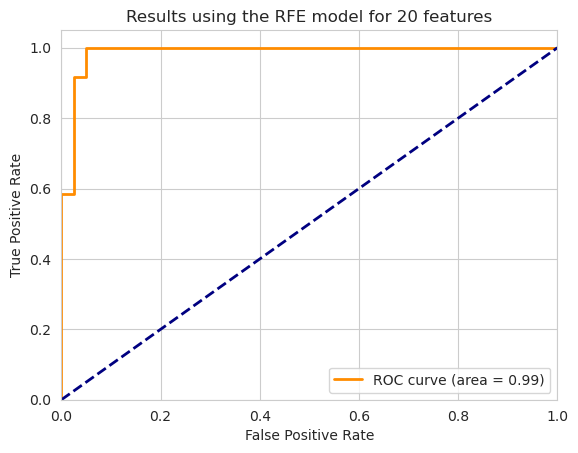

In [874]:
fig, ax = plt.subplots()
lw = 2
ax.plot(fpr, tpr, color="darkorange", lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc)
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f'Results using the RFE model for {selected_n} features')
ax.legend(loc="lower right")
plt.show()

# outfn = os.path.join(outdir, 'roc_curve.leave_one_out.svg')
# fig.savefig(outfn)

### ROC curve analysis with multiple models

In [875]:
results_loo = calculate_loo_validation_results(protein_data, task_data, selected_features_list, random_state)

In [876]:
# add back the "ALL" case
roc_rfe_selected_lists = rfe_selected_lists.copy()
roc_rfe_selected_lists.update({protein_data.shape[1]: protein_data.columns.tolist()})

num features: 3
num features: 4
num features: 5
num features: 6
num features: 7
num features: 8
num features: 9
num features: 10
num features: 11
num features: 12
num features: 13
num features: 14
num features: 15
num features: 16
num features: 17
num features: 18
num features: 19
num features: 20
num features: 250


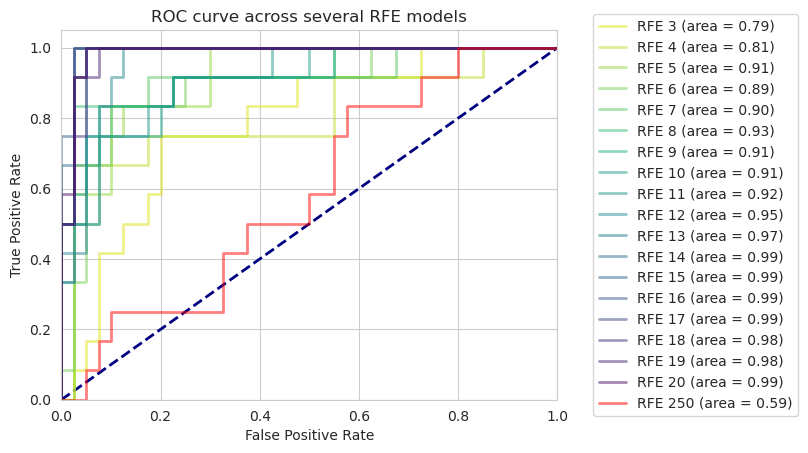

In [877]:
fig, ax = plt.subplots()
lw = 2
roc_colors = sns.color_palette('viridis_r', n_colors=len(roc_rfe_selected_lists) - 1).as_hex()
roc_colors.append('#FF0000')

# add skeleton elements
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f'ROC curve across several RFE models')

# add a line per model
i = 0
for current_n, curr_features_list in roc_rfe_selected_lists.items():
    print(f'num features: {current_n}')

    curr_results_loo = calculate_loo_validation_results(protein_data, task_data, curr_features_list, random_state)
    curr_results_loo_df = pd.DataFrame(curr_results_loo, columns=['train_acc', 'predicted', 'true', 'match', 'probs'])
    y_onehot_test = label_binarizer.transform(curr_results_loo_df['true'])
    y_onehot_preds = label_binarizer.transform(curr_results_loo_df['predicted'])

    # get the probabilities for each pred for a better roc curve
    y_prob_preds = np.vstack(curr_results_loo_df['probs'].values)[:,1]

    fpr, tpr, _ = roc_curve(y_onehot_test, y_prob_preds)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=roc_colors[i], lw=lw,
            label=f'RFE {current_n} (area = {roc_auc:.2f})', alpha=0.5)

    # update index counter
    i += 1 
    if i > 100:
        break

ax.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))
plt.show()

outfn = os.path.join(outdir, 'roc_curve.all_RFE_models.leave_one_out.svg')
fig.savefig(outfn)

In [878]:
outfn

'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/roc_curve.all_RFE_models.leave_one_out.svg'

### Saving a file with information on the 6 RFE model

In [879]:
# Create a new workbook
wb = Workbook()

# Create two sheets
sheet1 = wb.active
sheet1.title = "Sheet1"
sheet2 = wb.create_sheet(title="Sheet2")

# Lists of values
list1 = [1, 2, 3, 4, 5]
list2 = ['a', 'b', 'c', 'd', 'e']

# Add list2 to Sheet2
for idx, value in enumerate(list2, start=1):
    sheet2.cell(row=idx, column=1, value=value)

# Save the workbook
wb.save("example.xlsx")

In [880]:
# Fit the model on the training data
model = linear_model.LogisticRegression(random_state=0, max_iter=1000)
model.fit(protein_data.loc[:,selected_features_list], task_data)

# store the coefficients into a dataframe
coef_df = pd.DataFrame.from_dict({'protein': model.feature_names_in_.tolist(), 'coef': model.coef_.tolist()[0]}, orient='columns')
coef_df['abs_coef'] = coef_df['coef'].abs() 
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df['coef_cat'] = coef_df['coef'].apply(lambda x: '+' if x > 0 else '-')

In [881]:
# # plot the coefficients against one another
# fig, ax = plt.subplots(figsize=(6,4))
# sns.barplot(coef_df, x='protein', y='abs_coef', hue='coef_cat', palette={'+': '#b2182b', '-': '#2166ac'})
# ax.tick_params(axis='x', rotation=90)

# ax.legend(title='coef_cat', framealpha=1) 

# fig.tight_layout()

# coef_fn = os.path.join(outdir, 'logit_model.rfe_16_proteins.coefs.png')
# fig.savefig(coef_fn, dpi=300)

In [882]:
# # Save the DataFrame to an Excel file
# outfn = os.path.join(outdir, 'logit_model.rfe_16_proteins.coefs.xlsx')
# with pd.ExcelWriter(outfn, engine='openpyxl') as writer:
#     coef_df.to_excel(writer, sheet_name='Sheet1', index=False)

# # Load the workbook
# wb = load_workbook(outfn)

# # Select the sheet
# sheet = wb["Sheet1"]

# # Load an image
# img = Image(coef_fn)
# img.width = 6 * 96
# img.height = 4 * 96

# # Add the image to the sheet at a specific cell
# sheet.add_image(img, 'F2')

# # Save the workbook
# wb.save(outfn)

-
-
-
-
-

## Predicting the Non Visit 1 samples

In [883]:
# Load the protein levels data
nv1_protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t").T

# Load the clinical data
nv1_clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")
original_clinical_data = nv1_clinical_data.copy(deep=True)

# remove alamar samples
keep = (nv1_clinical_data.event_name != 1).tolist()
nv1_clinical_data = nv1_clinical_data.loc[keep,:]
nv1_protein_data = nv1_protein_data.loc[keep,:]

# # extract just CD and UC data
focus_idxs = np.argwhere(nv1_clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
nv1_clinical_data = nv1_clinical_data.iloc[focus_idxs]
nv1_protein_data = nv1_protein_data.iloc[focus_idxs, :]

In [884]:
nv1_protein_data.shape

(22, 250)

In [885]:
# generate predictions
nv1_preds = model.predict(nv1_protein_data.loc[:, selected_features_list])
nv1_clinical_data['cd_versus_uc_preds'] = nv1_preds

# generate probabilities for each prediction
cd_versus_uc_probs = model.predict_proba(nv1_protein_data.loc[:, selected_features_list])
cd_versus_uc_probs = [np.max(v) for v in cd_versus_uc_probs]
nv1_clinical_data['cd_versus_uc_probs'] = cd_versus_uc_probs

In [886]:
# reorganize according to matched_subject_id
nv1_clinical_data = nv1_clinical_data.sort_values(['matched_subject_id', 'original_subject_id']).set_index(['matched_subject_id', 'original_subject_id'])

# save the data
outfn = os.path.join(outdir, 'nv1_predictions.xlsx')
nv1_clinical_data.to_excel(outfn, index=False)

In [887]:
num_misclass = nv1_clinical_data.loc[nv1_clinical_data.ibd_diagnosis != nv1_clinical_data.cd_versus_uc_preds].shape[0]
num_corclass = nv1_clinical_data.loc[nv1_clinical_data.ibd_diagnosis == nv1_clinical_data.cd_versus_uc_preds].shape[0]

In [888]:
print(f'Accuracy = {num_corclass * 100 / (num_corclass + num_misclass):.2f}%')

Accuracy = 81.82%


In [889]:
7+

SyntaxError: invalid syntax (4228363174.py, line 1)

-
-
-
-
-

## Predicting the IBD-U samples

In [ ]:
# Load the protein levels data
ibdu_protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t").T

# Load the clinical data
ibdu_clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")
original_clinical_data = ibdu_clinical_data.copy(deep=True)

# remove alamar samples
keep = (~ibdu_clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
ibdu_clinical_data = ibdu_clinical_data.loc[keep,:]
ibdu_protein_data = ibdu_protein_data.loc[keep,:]

# extract just IBD-U data
focus_idxs = np.argwhere(ibdu_clinical_data['ibd_diagnosis'].isin(['IBD-U'])).reshape(-1)
ibdu_clinical_data = ibdu_clinical_data.iloc[focus_idxs]
ibdu_protein_data = ibdu_protein_data.iloc[focus_idxs, :]

In [ ]:
# generate predictions
ibdu_preds = model.predict(ibdu_protein_data.loc[:, selected_features_list])
ibdu_clinical_data['cd_versus_uc_preds'] = ibdu_preds

# generate probabilities for each prediction
cd_versus_uc_probs = model.predict_proba(ibdu_protein_data.loc[:, selected_features_list])
cd_versus_uc_probs = [np.max(v) for v in cd_versus_uc_probs]
ibdu_clinical_data['cd_versus_uc_probs'] = cd_versus_uc_probs

In [ ]:
# reorganize according to matched_subject_id
ibdu_clinical_data = ibdu_clinical_data.sort_values(['matched_subject_id', 'original_subject_id']).set_index(['matched_subject_id', 'original_subject_id'])

# save the data
outfn = os.path.join(outdir, 'ibdu_predictions.xlsx')
ibdu_clinical_data.to_excel(outfn, index=False)

In [ ]:
ibdu_clinical_data

### Diving into IBD-U samples using PCA with all RFE features

In [ ]:
# create full data for training samples
tdf = results_loo_df.copy()
tdf.index = protein_data.index.tolist()
full_data1 = pd.concat([protein_data, tdf], axis=1)

# create full data for ibd-u samples
full_data2 = ibdu_protein_data.copy()
full_data2.loc[:, 'predicted'] = ibdu_preds
full_data2.loc[:, 'true'] = 'IBD-U'
full_data2.loc[:, 'match'] = False

# concat
full_data_with_ibdu = pd.concat([full_data1, full_data2])

# do the same for clinical data
full_clinical_with_ibdu = pd.concat([clinical_data, ibdu_clinical_data])
full_clinical_with_ibdu.sort_index(inplace=True)

In [ ]:
full_data_with_ibdu.head()

In [ ]:
# Run PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(full_data_with_ibdu.loc[:, selected_features_list])

# make into a dataframe
principal_components = pd.DataFrame(principal_components, columns=['pc1', 'pc2', 'pc3'])

# add the index
principal_components.index = full_data_with_ibdu.index.tolist()

# add other columns
principal_components.loc[:, 'predicted'] = full_data_with_ibdu.loc[:, 'predicted']
principal_components.loc[:, 'true'] = full_data_with_ibdu.loc[:, 'true']
principal_components.loc[:, 'match'] = full_data_with_ibdu.loc[:, 'match']

# add the subject id
principal_components['matched_subject_id'] = full_clinical_with_ibdu.matched_subject_id.astype(str).values.tolist()

# # add subject error color depending on subjects that have at least one messed up sample
ibdu_subjects = full_clinical_with_ibdu.loc[full_clinical_with_ibdu.ibd_diagnosis == 'IBD-U', 'matched_subject_id'].unique().tolist()
principal_components['subject_ibdu_color'] = principal_components.matched_subject_id.apply(lambda x: x if float(x) in ibdu_subjects else 'other')

In [ ]:
principal_components.head()

In [ ]:
# Create a scatter plot of the PCA results
fig, ax = plt.subplots()
sns.scatterplot(x='pc1', y='pc2', hue='subject_ibdu_color', style='predicted', data=principal_components, ax=ax)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# outfn = os.path.join(outdir, 'pca.with_ibdu.rfe16.svg')
# fig.savefig(outfn)

In [ ]:
# Create a scatter plot of the PCA results
fig, ax = plt.subplots()
sns.scatterplot(x='pc1', y='pc2', hue='subject_ibdu_color', style='true', data=principal_components, ax=ax)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# outfn = os.path.join(outdir, 'pca.with_ibdu.rfe16.svg')
# fig.savefig(outfn)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [ ]:
tcolors = {'other': 'blue',
            "20.0": 'orange',
            '26.0': 'green',
            '25.0': 'red',
            '41.0': 'purple',
            '48.0': 'brown'}

In [ ]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

vcolors = [tcolors[x] for x in principal_components.subject_ibdu_color.tolist()]
ax.scatter(principal_components['pc1'], principal_components['pc2'], principal_components['pc3'], c=vcolors)
#ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show plot
plt.show()